In [19]:
%matplotlib inline

#!/usr/bin/env python3
# -*- coding:utf-8 -*-
u"""
@since 2019.06.24

A randomForest classifier on stage module
"""
import os
import math

import pandas as pd
import seaborn as sns
from anndata import AnnData
from matplotlib import gridspec as gridspec
from matplotlib import pyplot as plt
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.neighbors.classification import KNeighborsClassifier
from sklearn.model_selection import cross_validate
from sklearn.svm import SVC

In [2]:

STAGE = {
    "I": 1,
    "II": 2,
    "III": 3,
    "IV": 4
}


def load_data(path:str):
    u"""
    load data from specific path
    
    :param path: path to directory
    """
    
    # raw = pd.read_csv(os.path.join(path, "raw.csv.gz"), index_col=0, engine="python")
    scale = pd.read_csv(os.path.join(path, "scale.csv.gz"), index_col=0, engine="python")
    meta = pd.read_csv(os.path.join(path, "meta.csv.gz"), index_col=0, engine="python")
    
    data = AnnData(X=scale.transpose(), obs = meta)
    data.obs = meta
    # data.raw = raw
    
    return data
    
    
def perform_pca(data: AnnData, genes_use, n_comp=10):
    u"""
    Perform PCA
    :param data: AnnData
    :param genes_use: list of genes
    """ 
    pca = PCA(n_components=n_comp)
    
    mat = data.to_df()[genes_use].transpose()

    pca_res = pca.fit(mat)
    
    res = []
    
    for idx, comp in enumerate(pca_res.components_):
        comp = pd.DataFrame(comp)
        comp.index = mat.columns
        comp.columns = ["PC{}".format(idx + 1)]
        
        res.append(comp)
        
    return pd.concat(res, sort=False, axis=1)
    

def make_plots(data: AnnData, pca: pd.DataFrame, n_comp=10, ncol=3, dpi=300, output=None):
    u"""
    make combined scatter plots
    :param data: AnnData
    :param pca: DataFrame, columns is different PCs
    :param ncol: how many subplots in single row
    :param output: if None, plt.show
    """
    n_comp = min(n_comp, pca.shape[1])
    nrow = math.ceil((n_comp - 1) / ncol)
    
    fig = plt.figure(figsize=(nrow * 6, ncol * 6))
    gs = gridspec.GridSpec(nrow, ncol, figure=fig)
                           
    for i in range(n_comp - 1):
        curr_row = i // ncol
        curr_col = i % ncol
        
        curr_ax = plt.subplot(gs[curr_row, curr_col])
        
        temp = pca[["PC{}".format(i + 1), "PC{}".format(i + 2)]]
        temp = pd.concat([temp, data.obs["Stage"]], axis=1)

        sns.scatterplot(
            x="PC{}".format(i + 1), 
            y="PC{}".format(i + 2), 
            hue="Stage", 
            ax=curr_ax, 
            data=temp,
        )
        
    plt.tight_layout()
    if output:
        plt.savefig(output, dpi=dpi)
    else:
        plt.show()


def  train_random_forest(data: AnnData, genes_use=None, n_estimitors=100, max_depth=2, random_state=0, n_jobs=10):
    u"""
    train random forest by mfuzz
    
    :param data
    """
    
    if genes_use is None:
        genes_use = data.to_df().column

    clf = RandomForestClassifier(n_estimators=100, max_depth=2, random_state=0, n_jobs=n_jobs)
    
    mat = data.to_df()[genes_use]
    stage = data.obs.loc[mat.index, ["Stage"]]

    stage = [STAGE[x] for x in stage["Stage"]]
    
    clf.fit(mat, stage)
    
    features = pd.DataFrame(
        data = clf.feature_importances_,
        index = mat.columns,
        columns=['importance']
    ).sort_values('importance', ascending=False)
    
    return clf, features


def find_best_features(
    data: AnnData, 
    test_set: AnnData, 
    disease: str, 
    init_features=None, 
    n_iter=10, 
    random_state=0, 
    n_estimitors=100, 
    max_depth=2, 
    n_jobs=10
):
    u"""
    find best features
    """

    clf, features = train_random_forest(
        data, 
        init_features, 
        random_state=random_state, 
        n_jobs=n_jobs,
        n_estimitors=100, 
        max_depth=2
    )

    res = []
    for i in range(n_iter):
        test_Y = test_set.obs.loc[test_set.obs["Disease"] == disease, ["Stage"]]
        test_X = test_set.to_df().loc[test_Y.index, features.index]

        temp = clf.predict(test_X)

        fpr, tpr, thresholds = metrics.roc_curve([STAGE[x] for x in test_Y["Stage"]], temp.tolist(), pos_label=2)

        s_ = [
            features,
            metrics.auc(fpr, tpr),
            metrics.accuracy_score([STAGE[x] for x in test_Y["Stage"]], temp.tolist())
        ]
        
        res.append(s_)
        clf, features = train_random_forest(
            data, 
            features.loc[features["importance"] > 0, :].index, 
            random_state=random_state, 
            n_jobs=n_jobs,
            n_estimitors=100, 
            max_depth=2
        )
    
    for i in res:
        print([i[0].shape, i[1], i[2]])
        
    return res



def make_violin_of_test_score(data, figsize=None, output=None):
    u"""
    make violin plot of score
    """
    
    res = []
    for i in data:
        for j in i["test_score"]:
            res.append([i["iter"], j])
    
    res = pd.DataFrame(res, columns=["ident", "score"])
    
    if figsize:
        fig, ax = plt.subplots(figsize=figsize)
    else:
        fig, ax = plt.subplots()
    sns.violinplot(x="ident", y="score", ax=ax, data=res)
    
    plt.tight_layout()
    if output:
        plt.savefig(output, dpi = 600)
    else:
        plt.show()

In [26]:

def find_best_features_by_cv(
    data: AnnData, 
    init_features=None, 
    n_iter=10, 
    random_state=0, 
    n_estimitors=100, 
    max_depth=2, 
    n_jobs=10,
    cv=10
):
    u"""
    Find best features by crossvalidation
    :param data: 
    """

    rf = RandomForestClassifier(n_estimators=n_estimitors, max_depth=max_depth, random_state=random_state, n_jobs=n_jobs)
    
    if init_features is None:
        init_features = data.to_df().columns
        
    res = []
    for i in range(n_iter):
        mat = data.to_df().loc[:, init_features]
        cv_results = cross_validate(rf, X=mat, y=data.obs["Stage"], cv=cv, n_jobs=n_jobs, return_estimator=True)
    
        res.append(
            {
                "iter": i,
                "test_score": cv_results["test_score"],
                "features": init_features
            }
        )
        
        importance = [] 
        for idx, estimator in enumerate(cv_results["estimator"]):
            importance.append(
                pd.DataFrame(
                    estimator.feature_importances_,
                    index=init_features,
                )
            )


        importance = pd.concat(importance, axis=1)
        
        importance = importance > 0
        importance = importance.sum(axis=1)
        
        init_features = importance[importance > (cv / 2)].index
        
    return res


def find_best_features_by_cv_knn(
    data: AnnData, 
    init_features=None, 
    max_neighbors=30,
    n_iter=10, 
    random_state=0, 
    n_jobs=10,
    cv=10
):
    u"""
    Find best features by crossvalidation
    :param data: 
    """

    
    
    if init_features is None:
        init_features = data.to_df().columns
        
    res = []
    mat = data.to_df().loc[:, init_features]
    
    for i in range(3, max_neighbors + 1):
        knn = KNeighborsClassifier(n_neighbors=i)
        cv_results = cross_validate(knn, X=mat, y=data.obs["Stage"], cv=cv, n_jobs=n_jobs, return_estimator=False)

        res.append(
            {
                "iter": i,
                "test_score": cv_results["test_score"],
                # "features": init_features
            }
        )
                
    return res


def find_best_features_by_cv_svm(
    data: AnnData, 
    init_features=None, 
    max_neighbors=30,
    n_iter=10, 
    random_state=0, 
    n_jobs=10,
    cv=10
):
    u"""
    Find best features by crossvalidation
    :param data: 
    """

    
    
    if init_features is None:
        init_features = data.to_df().columns
        
    res = []
    mat = data.to_df().loc[:, init_features]
    
    for i in ['linear', 'poly', 'rbf', 'sigmoid']:
        print(i)
        svc = SVC(
            C=1.0, 
            kernel=i, 
            degree=3, 
            gamma='auto_deprecated', 
            coef0=0.0, 
            shrinking=True, 
            probability=False, 
            tol=0.001, 
            cache_size=200, 
            class_weight=None, 
            verbose=False, 
            max_iter=-1, 
            decision_function_shape='ovr', 
            random_state=random_state
        )
        cv_results = cross_validate(svc, X=mat, y=data.obs["Stage"], cv=cv, n_jobs=n_jobs, return_estimator=False)

        res.append(
            {
                "iter": i,
                "test_score": cv_results["test_score"],
                # "features": init_features
            }
        )
                
    return res

In [4]:

features = [
    'GPC4', 'CYBA', 'ELF3', 'AZGP1', 'FKBP5', 'MUC1', 'TSC22D3', 'C4BPA',
       'MT2A', 'XIST', 'SCGB3A1', 'FAM84B', 'MBNL3', 'SPINK1', 'HLA-DQA2',
       'MT-RNR1', 'CHCHD2', 'HLA-DRB5', 'TAGLN2', 'POLR2J3-1', 'ERBB3',
       'CEACAM6', 'TFPI', 'SFTPC', 'QPRT', 'RNASE1', 'MT1E', 'SEC61G', 'EPS8',
       'CEACAM5', 'RPS4Y1', 'FABP5', 'MT-ND5', 'RPS19', 'MUC21', 'MT-ND4L',
       'AREG', 'SOX4', 'DRAM1', 'CTGF', 'DDIT4', 'EGR1', 'NET1', 'B3GNT7',
       'SCGB3A2', 'CD74', 'TRIB1', 'CP', 'RPS26', 'HMGN3', 'APLP2', 'PRR15L',
       'MYO6', 'MYLIP', 'PRSS8', 'C3', 'EFNA1', 'FOSB', 'BCAP31', 'JUNB',
       'S100A6', 'WNK1', 'PMAIP1'
]

In [ ]:
### Load data

In [8]:
data = load_data("/mnt/raid62/Lung_cancer_10x/02_figures_each_cell/Alveolar_II_ADC/paga")

mfuzz = pd.read_excel("/mnt/raid62/Lung_cancer_10x/02_figures_each_cell/Alveolar_II_ADC/mfuzz_gene_module/results.xlsx")

# pca_res = perform_pca(data, mfuzz["gene"].unique())

# make_plots(data, pca=pca_res, output="/mnt/raid62/Lung_cancer_10x/project_scripts/pca.png")

# test_set = load_data("/mnt/raid62/Lung_cancer_10x/02_figures_each_cell/Alveolar_II/paga")


# best_features = find_best_features(
#     train, test, disease="ADC",
#     init_features=mfuzz["gene"].unique()
# )
        

# pca_best_features = perform_pca(data, best_features[3][0].index)
# make_plots(data, pca=pca_best_features, output="/mnt/raid62/Lung_cancer_10x/project_scripts/pca_best_features.png")


## RandomForest

#### all genes

0.701517911353977 0.7111111111111111
0.7437765634486947 0.7777777777777778
0.7547965998785671 0.7944444444444444
0.7565877352762599 0.7888888888888889
0.7659684274438373 0.8388888888888889
0.7785670916818458 0.8111111111111111
0.7602003642987248 0.7833333333333333
0.7565877352762599 0.7888888888888889
0.7638737097753491 0.7888888888888889
0.765725561627201 0.7944444444444444
0.7750151791135398 0.8277777777777777
0.7603521554341226 0.8111111111111111
0.7602914389799637 0.8
0.765725561627201 0.7944444444444444
0.76578627808136 0.8055555555555556
0.7712204007285974 0.8
0.767577413479053 0.8
0.7658166363084394 0.8111111111111111
0.7602003642987248 0.7833333333333333
0.7730722525804493 0.8055555555555556
0.776775956284153 0.8166666666666667
0.76578627808136 0.8055555555555556
0.7749241044323011 0.8111111111111111
0.7677595628415301 0.8333333333333334
0.7602914389799637 0.8
0.7712507589556769 0.8055555555555556
0.7731633272616879 0.8222222222222222
0.7803582270795385 0.8055555555555556
0.776

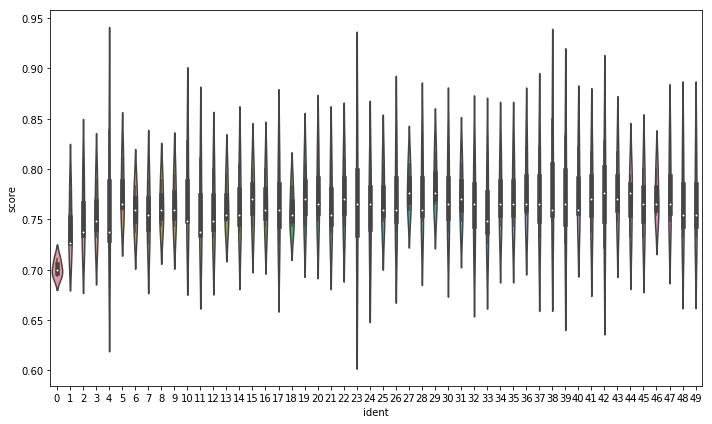

In [13]:
# cv_results_all = find_best_features_by_cv(data, init_features=None, n_iter=50, random_state=0, n_estimitors=100, max_depth=None, n_jobs=10, cv=3)
for i in cv_results_all:
    print(sum(i["test_score"]) / len(i["test_score"]), max(i["test_score"]))
    
make_violin_of_test_score(cv_results_all, figsize=(10, 6))

#### mfuzz genes

In [14]:
cv_results_mfuzz = find_best_features_by_cv(data, init_features=mfuzz["gene"].unique(), n_iter=1, random_state=0, n_estimitors=100, max_depth=None, n_jobs=10, cv=3)
for i in cv_results_mfuzz:
    print(sum(i["test_score"]) / len(i["test_score"]), max(i["test_score"]))

0.7842137219186399 0.8444444444444444


#### 63 genes

In [15]:
cv_results = find_best_features_by_cv(data, init_features=features, n_iter=1, random_state=0, n_estimitors=100, max_depth=None, n_jobs=10, cv=3)
for i in cv_results:
    print(sum(i["test_score"]) / len(i["test_score"]), max(i["test_score"]))

0.7933819064966605 0.8555555555555555


## KNN

#### all genes

0.5145818070818071 0.6
0.5876784326784327 0.7272727272727273
0.5201921226921227 0.6363636363636364
0.5760449735449735 0.6428571428571429
0.5249387649387649 0.6363636363636364
0.570390812890813 0.6909090909090909
0.5338724238724238 0.6363636363636364
0.5690622340622341 0.6607142857142857
0.5672314722314722 0.6545454545454545
0.575034965034965 0.6545454545454545
0.5858740333740333 0.6363636363636364
0.5877372627372628 0.625
0.5804194879194878 0.6428571428571429
0.5658016058016058 0.625
0.5842641617641617 0.6428571428571429
0.5878731453731454 0.6428571428571429
0.578946978946979 0.6428571428571429
0.5917791467791467 0.6428571428571429
0.5737909312909313 0.6346153846153846
0.5791880341880342 0.6538461538461539
0.5845052170052171 0.6538461538461539
0.5917466792466792 0.6538461538461539
0.5827195027195028 0.6346153846153846
0.5881415806415806 0.6346153846153846
0.5791156066156067 0.6428571428571429
0.5883462833462832 0.6481481481481481
0.586428293928294 0.6545454545454545
0.5992616642616643 

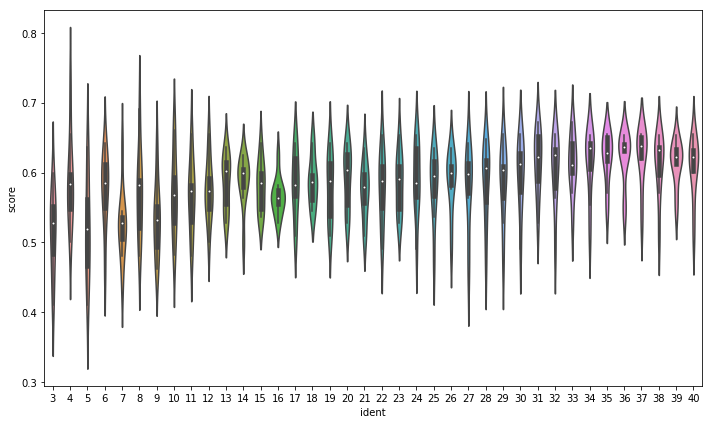

In [16]:
knn_res_all = find_best_features_by_cv_knn(data, max_neighbors=40)
for i in knn_res_all:
    print(sum(i["test_score"]) / len(i["test_score"]), max(i["test_score"]))

make_violin_of_test_score(knn_res_all, figsize=(10, 6))

#### mfuzz genes

0.8367023717023716 0.9423076923076923
0.8122730972730972 0.8909090909090909
0.8291224516224516 0.9272727272727272
0.8249354349354349 0.9272727272727272
0.8363028638028638 0.9454545454545454
0.8289177489177488 0.9272727272727272
0.8287428312428311 0.9090909090909091
0.8211605061605061 0.9090909090909091
0.8249342324342324 0.9090909090909091
0.8212591112591113 0.8909090909090909
0.8250003700003701 0.9090909090909091
0.8232870832870833 0.8909090909090909
0.8232221482221483 0.8909090909090909
0.8305673030673031 0.8909090909090909
0.8248642098642099 0.8909090909090909
0.8358856883856884 0.9090909090909091
0.8377438302438304 0.8909090909090909
0.8302538202538201 0.9090909090909091
0.8375015725015725 0.9090909090909091
0.8358919783919785 0.9090909090909091
0.834001369001369 0.9272727272727272
0.8249741924741925 0.9090909090909091
0.8192761867761866 0.9454545454545454
0.8191063566063566 0.9090909090909091
0.813645521145521 0.9272727272727272
0.8099093499093499 0.9272727272727272
0.817425537425

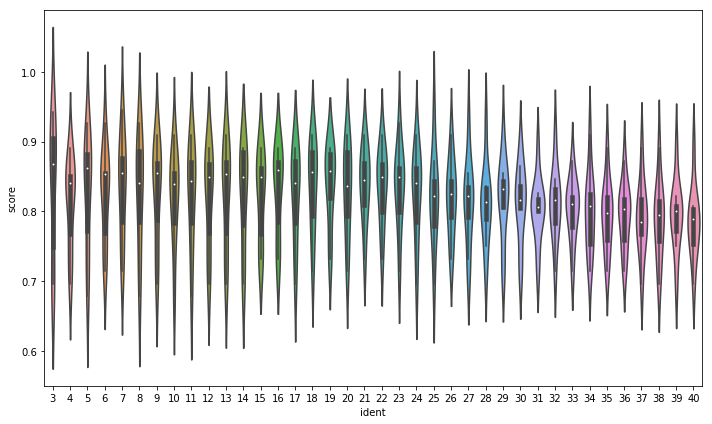

In [17]:
knn_res_mfuzz = find_best_features_by_cv_knn(data, init_features=mfuzz["gene"].unique(), max_neighbors=40)
for i in knn_res_mfuzz:
    print(sum(i["test_score"]) / len(i["test_score"]), max(i["test_score"]))

make_violin_of_test_score(knn_res_mfuzz, figsize=(10, 6))

#### 63 genes

0.8381484256484256 0.9454545454545454
0.8527687127687129 0.9272727272727272
0.8476264476264476 0.9230769230769231
0.8475227550227551 0.9454545454545454
0.8494070744070745 0.9272727272727272
0.8531158656158656 0.9423076923076923
0.8563452288452289 0.9272727272727272
0.8546992821992822 0.9230769230769231
0.8566211566211566 0.9423076923076923
0.8511603211603213 0.9272727272727272
0.8496168646168647 0.9423076923076923
0.8547642172642173 0.9423076923076923
0.8454623154623155 0.9272727272727272
0.8489288489288491 0.9272727272727272
0.8527088652088652 0.9272727272727272
0.8471157546157547 0.9272727272727272
0.8395944795944796 0.9272727272727272
0.8450553150553152 0.9272727272727272
0.8431647056647057 0.9272727272727272
0.8412467162467161 0.9272727272727272
0.8432034632034631 0.9272727272727272
0.8395334295334294 0.9090909090909091
0.839494671994672 0.9090909090909091
0.8340052540052539 0.9090909090909091
0.833967698967699 0.9090909090909091
0.833967698967699 0.9090909090909091
0.8267935767935

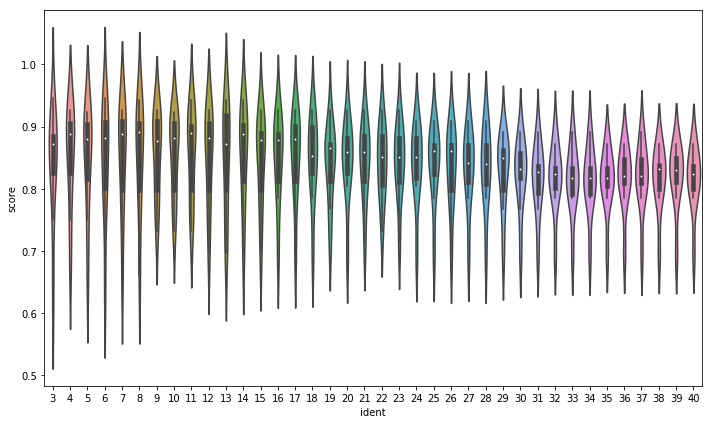

In [18]:
knn_res = find_best_features_by_cv_knn(data, init_features=features, max_neighbors=40)
for i in knn_res:
    print(sum(i["test_score"]) / len(i["test_score"]), max(i["test_score"]))
    
make_violin_of_test_score(knn_res, figsize=(10, 6))

## SVM

linear
poly
rbf
sigmoid
0.8106908831908832 0.8727272727272727
0.35179477929477926 0.37037037037037035
0.7506335331335331 0.8461538461538461
0.790447422947423 0.8518518518518519


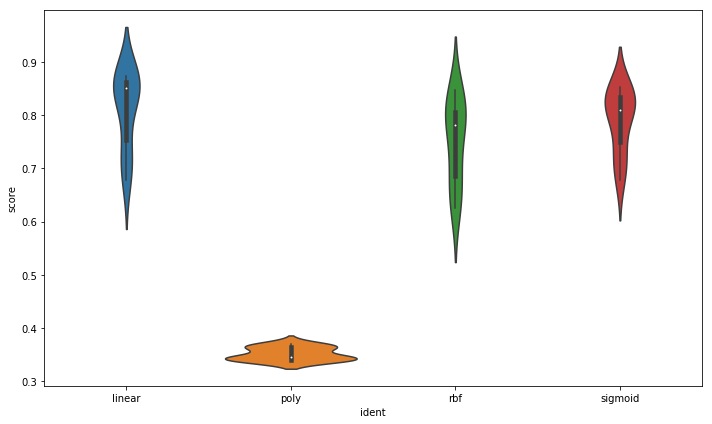

In [28]:
svm_all = find_best_features_by_cv_svm(data)

for i in svm_all:
    print(sum(i["test_score"]) / len(i["test_score"]), max(i["test_score"]))
    
make_violin_of_test_score(svm_all, figsize=(10, 6))

linear
poly
rbf
sigmoid
0.8310878935878936 0.9230769230769231
0.741054501054501 0.8363636363636363
0.8508843933843933 0.9230769230769231
0.8510280460280459 0.9423076923076923


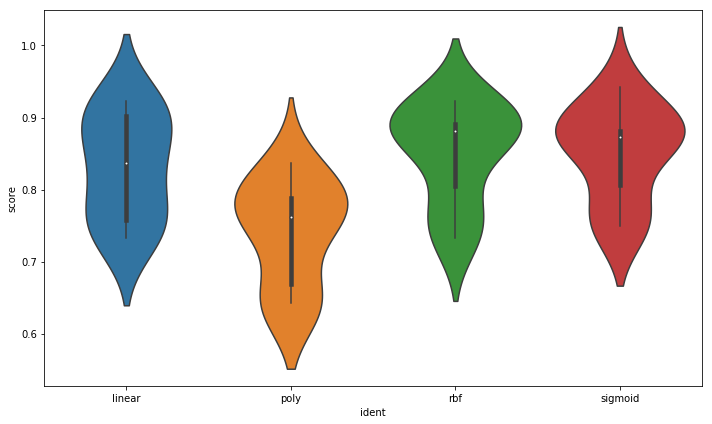

In [30]:
svm_mfuzz = find_best_features_by_cv_svm(data, init_features=mfuzz["gene"].unique())

for i in svm_mfuzz:
    print(sum(i["test_score"]) / len(i["test_score"]), max(i["test_score"]))
    
make_violin_of_test_score(svm_mfuzz, figsize=(10, 6))

linear
poly
rbf
sigmoid
0.7758497058497058 0.8909090909090909
0.850898175898176 0.9423076923076923
0.8695906870906871 0.9615384615384616
0.8416873866873867 0.9090909090909091


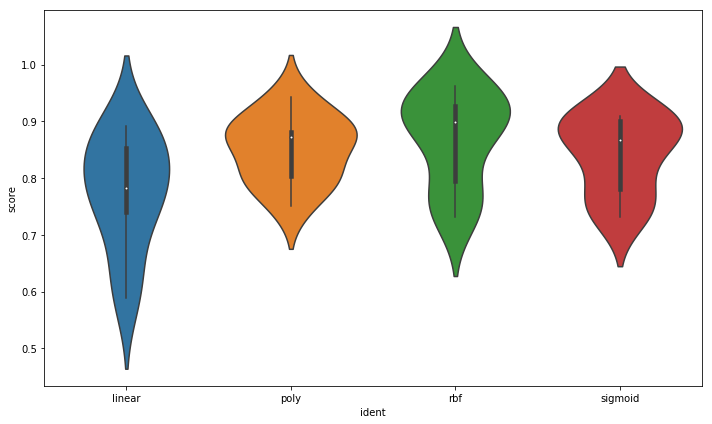

In [31]:
svm = find_best_features_by_cv_svm(data, init_features=features)

for i in svm:
    print(sum(i["test_score"]) / len(i["test_score"]), max(i["test_score"]))
    
make_violin_of_test_score(svm, figsize=(10, 6))